# Kidney Cancer Bayesian Data Analysis

Alex Chen

Data Source: https://github.com/robinryder/BDA-kidney

Supplementation: https://data102.org/ds-102-book/content/chapters/02/02_hierarchical_models.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az

import jax
from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive

plt.style.use("bmh")

# seed for reproducibility
seed_split = 42
seed_jax_rng = random.PRNGKey(0)

# parameters settings
num_samples = 2000    # #samples from MCMC
num_warmup = 1000     # #warmups
num_pp_samples = 500  # #samples for posterior
num_chains = 2        # # MCMC chains
num_comps = 3         # #components in GMM

# try to use more device count for more speed up
dev_cnt = jax.local_device_count()
dev_mcmc = num_chains if dev_cnt >= num_chains else dev_cnt
numpyro.set_host_device_count(dev_mcmc)

# run model utility function
def _run_model(model, data, seed = seed_jax_rng, num_warmup = num_warmup, num_samples = num_samples, num_chains = num_chains, init_params = None):
    _, rng_key = random.split(seed)
    mcmc = MCMC(
        NUTS(model),
        num_warmup = num_warmup,
        num_samples = num_samples,
        num_chains = num_chains
    )

    mcmc.run(
        rng_key,
        **data,
        extra_fields=('energy',),  # to enable energy plot
        init_params = init_params
    )
    return mcmc

/Users/alex/CAPE/BDA/kidney-cancer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import the Dataset

In [2]:
df = pd.read_csv('KidneyCancerClean.csv', skiprows = 4)
df = df.loc[:, ['state', 'Location', 'dc', 'dc.2', 'pop', 'pop.2']]  # population & cancer death for two time periods
df['rate'] = df['dc'] / df['pop']
df.head()

,state,Location,dc,dc.2,pop,pop.2,rate
0,ALABAMA,"Autauga County, Alabama",2,1,61921,64915,0.000032
1,ALABAMA,"Baldwin County, Alabama",7,15,170945,195253,0.000041
2,ALABAMA,"Barbour County, Alabama",0,1,33316,33987,0.000000
3,ALABAMA,"Bibb County, Alabama",0,1,30152,31175,0.000000
4,ALABAMA,"Blount County, Alabama",3,5,88342,91547,0.000034


# Data Visualisation

Text(0.5, 1.0, 'Cancer Deaths')

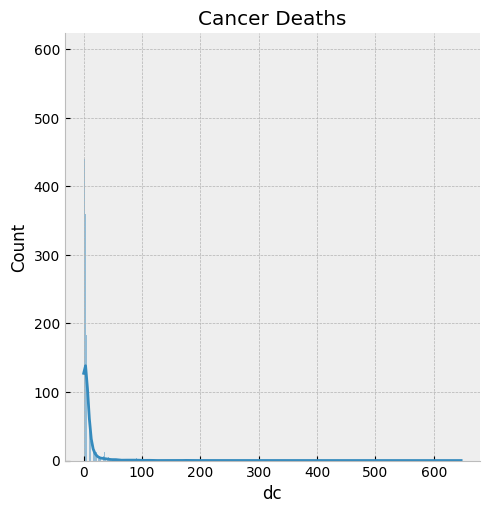

In [3]:
sns.displot(df['dc'], kde=True)
plt.title('Cancer Deaths')

The number of deaths contains lots of 0 and a few extreme values. These make the distribution highly skewed.

In [4]:
df.describe()

,dc,dc.2,pop,pop.2,rate
count,3110.000000,3110.000000,3.110000e+03,3.110000e+03,3110.000000
mean,7.527974,8.359164,1.550087e+05,1.606611e+05,0.000050
std,23.095402,23.765728,4.722345e+05,4.972750e+05,0.000044
min,0.000000,0.000000,2.580000e+02,2.670000e+02,0.000000
25%,1.000000,1.000000,2.238250e+04,2.213000e+04,0.000023
50%,2.000000,3.000000,4.762800e+04,4.806950e+04,0.000045
75%,6.000000,7.000000,1.146262e+05,1.179355e+05,0.000070
max,647.000000,598.000000,1.526640e+07,1.660789e+07,0.000452


Text(0.5, 1.0, 'Cancer Deaths vs Population')

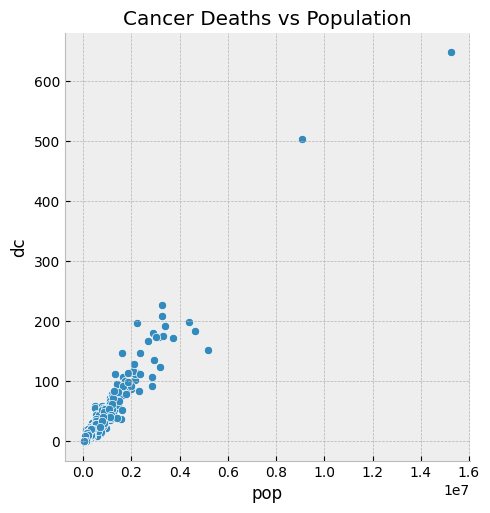

In [5]:
sns.relplot(x = 'pop', y = 'dc', data = df)
plt.title('Cancer Deaths vs Population')

As seen in the plot, the population and the number of deaths are highly correlated.

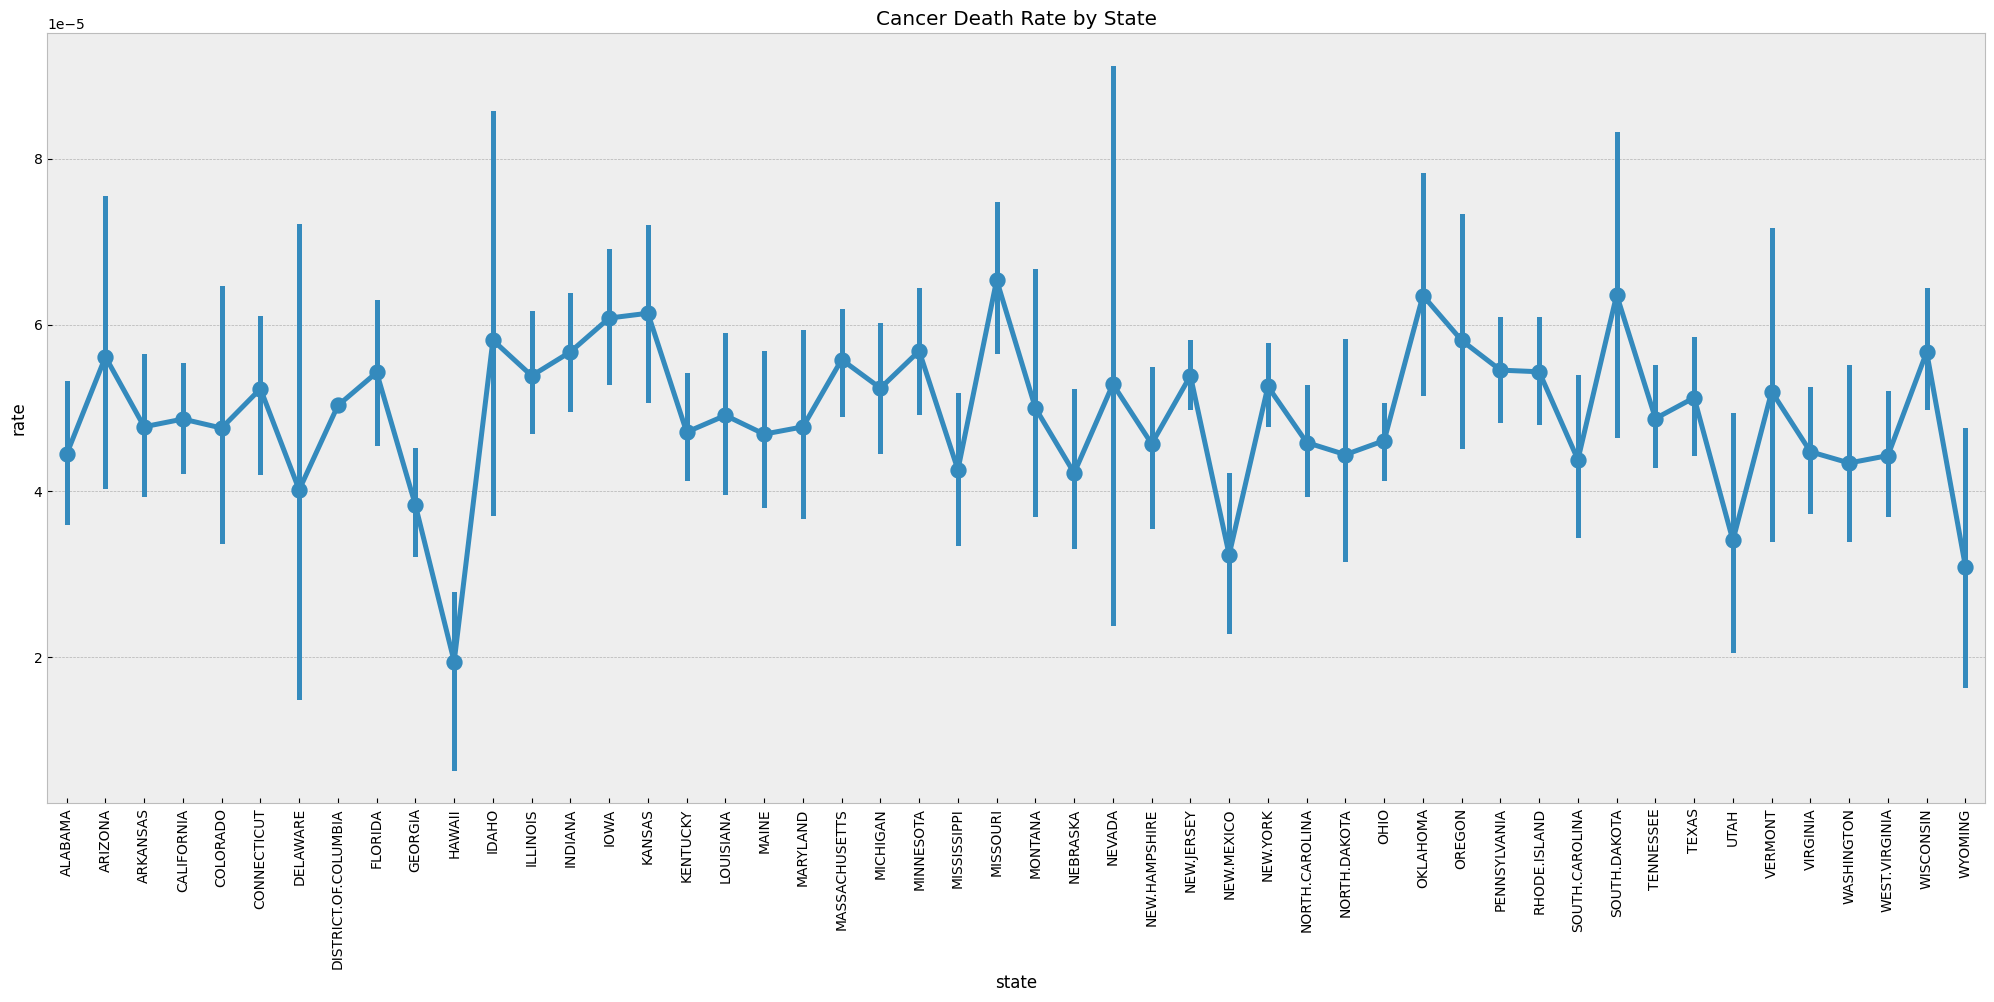

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.pointplot(x = 'state', y = 'rate', data = df, ax=ax)
plt.xticks(rotation=90)
plt.title('Cancer Death Rate by State')
plt.show()

From the plot above, the death rates in different states are different. Besides, some differences are significant.

Text(0.5, 0.98, 'Cancer Deaths by State')

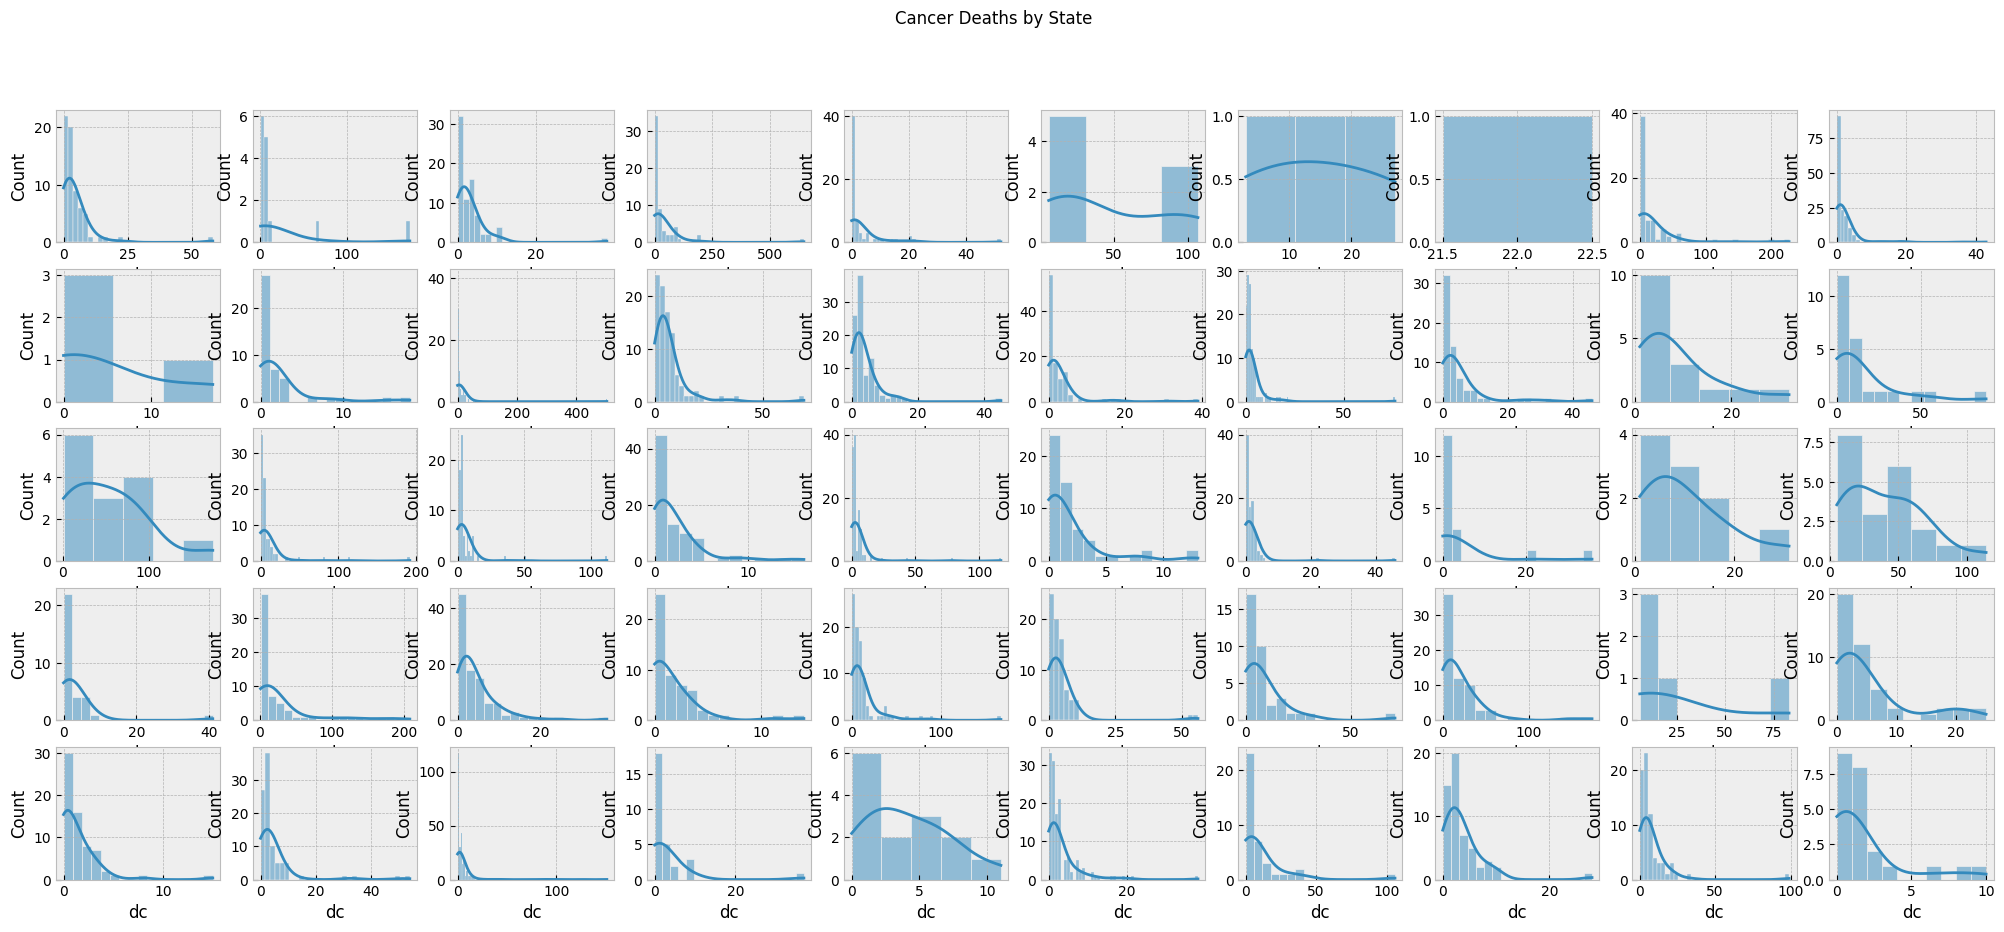

In [7]:
fig, ax = plt.subplots(5, 10, figsize=(25, 10))

for i, st in enumerate(df.state.unique()):
    sns.histplot(df.loc[df.state == st, 'dc'], kde=True, ax=ax[i//10, i%10])

plt.suptitle('Cancer Deaths by State')

In most states, the number of deaths follows the similar distribution. That is, a highly-skewed distribution.

# Modelling


To fit such data, it is reasonable to use zero-inflated distribution because lots of data are zero. The most well-known zero-inflated distribution is zero-inflated poisson. Although it is suitable for the counting data, it requires the data distributed in a pattern that the mean roughly equals to the standard deviation, which is not the case for the dataset. Instead, I need a overdispersed poisson distribution. Zero-inflated negative binomial distribution does a great job in this situation. Hence I am going to use this as my likelihood distribution.

$$ dc \sim \text{ZeroInflatedNegativeBinomial}(\rho, \lambda, \kappa) $$

, where $\rho$ is the concentration (shape parameter in a gamma distribution), $\lambda$ is the mean value of the data subject to this negative binomial distribution (rate $\lambda$ in Poisson($\lambda$)), and $\kappa$ is the gate.

Noted that in `numpyro`, it expresses negaitve binomial in Gamma-Poisson mixture fashion, coded in `GammaPoisson`, `NegativeBinomial2` and `ZeroInflatedNegativeBinomial2`. It is different from another common formula used in `numpy`, which contains two parameters $r,p$, where $r$ is the number of successes until the experiment is stopped, and $p$ is the sucess probability.

The relationship between two expressions is shown as follows,

in Gamma-Poisson mixture (Gamma distribution is expressed in shape-rate fashion),

$$
\begin{cases}
    Y \sim \text{Pois}(\lambda)\\
    \lambda \sim \text{Gamma}(\rho, \frac{1-p}{p})
\end{cases}
$$

and in Negative Binomial distribution $ Y \sim \text{NB}(r, p) $,

then $\rho=r$ and the $p$ in $\frac{1-p}{p}$ in Gamma-Poisson mixture is equivalent to $p$ in Negative Binomial distribution.

To summarise, in `numpyro`, there are three ways to express a negative binomial distribution: `GammaPoisson`, `NegativeBinomial`, and `NegativeBinomial2`. They can be written as $\text{GP}(\alpha, \beta)$ (where $\alpha, \beta$ are parameters from a gamma distribution), $\text{NB}(r, p)$, and $\text{NB2}(c, \lambda)$ respectively. The relationships between the three are:

$$\alpha=r=c(=\rho)$$

$$\beta=\frac{1}{p}-1=\frac{c}{\lambda}$$

For the second equation, the first part holds because $\beta=\frac{1-p}{p}$ and the second part holds because the mean of a gamma distribution is $\frac{\alpha}{\beta}$, which is also the mean of a Gamma-Poisson mixture $\lambda$. It is easy to deduct that $\beta=\frac{c}{\lambda}$.

In the Data Visualisation section, I know that the states have an impact on the number of deaths. As a result, it is reasonable to calculate the number of deaths separated by states.I also use population as a predictor. The model looks like this:

$$ dc \sim \text{ZeroInflatedNegativeBinomial}(\rho, \lambda_{\text{state}}, \kappa_{\text{state}}) $$

$$ \rho \sim \text{Exponential}(1) $$

$$ \kappa_{\text{state}} \sim \text{Beta}(1, 5)$$

$$ \lambda_{\text{state}} = \rho \times \omega_{\text{state}} $$

$$ \omega_{\text{state}} = \phi_{\text{state}} \times X_{\text{pop}} $$

$$ \phi_{\text{state}} \sim \text{Beta}(1, 1e6) $$

For $\rho$, I think that the value should be around 1 because the shape of the distribution will be more like what we have in the dataset. For $\kappa$, the percentage of 0 is around 0.2, and the negative binomial distribution can contribute some 0s per se, so I believe that the real $\kappa$ is smaller than 0.2, which can be described by the selected distribution. For $\lambda$, We can deduct that $\lambda = \frac{cp}{1-p}$, and I set $\frac{p}{1-p}=\omega$, which is composed of $\phi_{\text{state}}$ and $X_{\text{pop}}$. From the experiments below, I know that $p$ should close to 0.01, yielding that the scale of $\omega$ is at magnitude around $1e-2$. Because the scales of $X_{\text{pop}}$ are around $1e4$, it is reasonable that and the value of $\phi$ is in a scale of $1e-6$, which can be achieved by the selected prior.


Reference:

https://en.wikipedia.org/wiki/Negative_binomial_distribution

https://timothy-barry.github.io/posts/2020-06-16-gamma-poisson-nb/

https://num.pyro.ai/en/stable/_modules/numpyro/distributions/conjugate.html#ZeroInflatedNegativeBinomial2

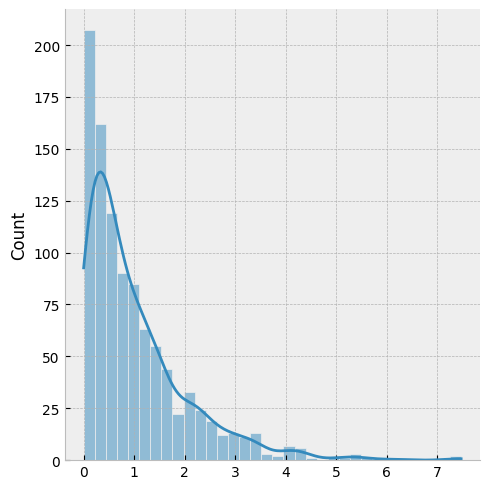

In [8]:
# the prior of rho

rng = np.random.default_rng(seed_split)
sns.displot(rng.exponential(1, size=1000), kde=True)

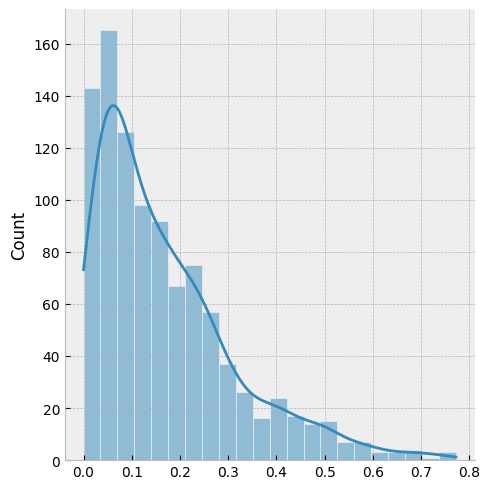

In [9]:
# the prior of kappa

rng = np.random.default_rng(seed_split)
sns.displot(rng.beta(1, 5, size=1000), kde=True)

In [10]:
# the scale of pop

df['pop'].describe()

count    3.110000e+03
mean     1.550087e+05
std      4.722345e+05
min      2.580000e+02
25%      2.238250e+04
50%      4.762800e+04
75%      1.146262e+05
max      1.526640e+07
Name: pop, dtype: float64

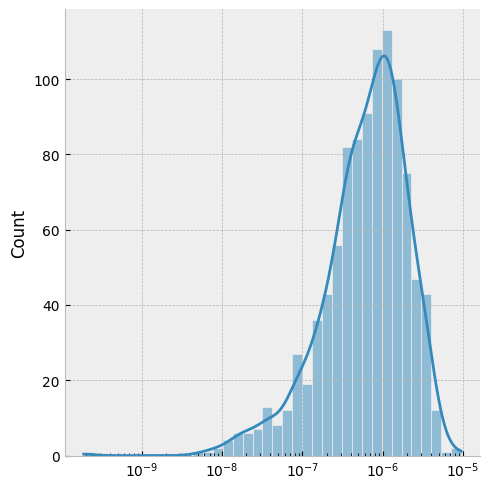

In [11]:
# the prior of phi

rng = np.random.default_rng(seed_split)
sns.displot(rng.beta(1, 1e6, size = 1000), kde=True, log_scale=(True, False))

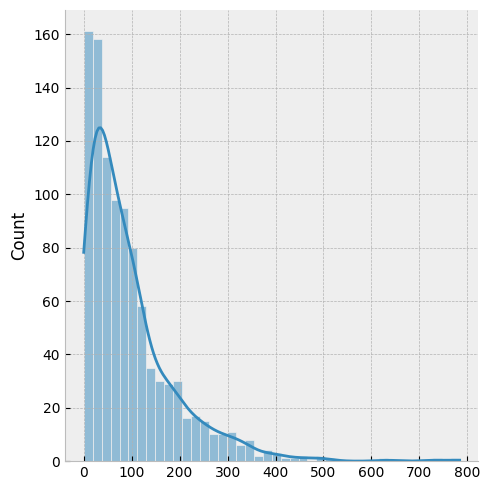

In [12]:
# experiment with negative binomial, the selected parameters can produce a distribution similar to the observed data

rng = np.random.default_rng(seed_split)
sns.displot(rng.negative_binomial(1, 0.01, size = 1000), kde=True)

In [13]:
# encode the state to integer

state_list = list(df['state'].unique())

location = []
for i in range(len(df)):
    location.append(state_list.index(df['state'].values.copy()[i]))

In [14]:
def model(location, population, death = None):
    num_locations = len(np.unique(location))
    rho = numpyro.sample('rho', dist.Exponential(1.0))

    with numpyro.plate('locations', num_locations):
        kappa = numpyro.sample('kappa', dist.Beta(1.0, 5.0))
        phi = numpyro.sample('phi', dist.Beta(1.0, 1e6))

    chosen_kappa = jnp.take(kappa, location.astype(int), axis = 0)
    chosen_phi = jnp.take(phi, location.astype(int), axis = 0)
    omega = numpyro.deterministic('omega', chosen_phi * population)
    with numpyro.plate('data', len(location)):
        numpyro.sample('death', dist.ZeroInflatedNegativeBinomial2(
            concentration = rho,
            mean = omega * rho,
            gate = chosen_kappa
        ), obs = death)


data = dict()
data['death'] = df['dc'].values.copy()
data['location'] = np.array(location, dtype = int)
data['population'] = df['pop'].values.copy()

# numpyro.render_model(
#     model = model,
#     model_args = (data.values()),
#     render_params = True,
#     render_distributions = True)

In [15]:
mcmc = _run_model(model, data)
mcmc.print_summary()

/var/folders/zz/x65716_j4s7947htd3809l4h0000gn/T/ipykernel_89050/983848280.py:37: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 3000/3000 [00:47<00:00, 63.19it/s, 31 steps of size 1.16e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  kappa[0]      0.04      0.03      0.04      0.00      0.09   6591.94      1.00
  kappa[1]      0.05      0.05      0.04      0.00      0.11   6026.36      1.00
  kappa[2]      0.04      0.03      0.03      0.00      0.08   6650.73      1.00
  kappa[3]      0.02      0.02      0.01      0.00      0.04   4680.57      1.00
  kappa[4]      0.03      0.03      0.02      0.00      0.07   5327.28      1.00
  kappa[5]      0.07      0.07      0.05      0.00      0.16   6679.98      1.00
  kappa[6]      0.11      0.10      0.08      0.00      0.26   5827.91      1.00
  kappa[7]      0.14      0.12      0.11      0.00      0.32   6576.19      1.00
  kappa[8]      0.03      0.03      0.02      0.00      0.07   5748.16      1.00
  kappa[9]      0.03      0.02      0.02      0.00      0.07   6909.14      1.00
 kappa[10]      0.15      0.12      0.12      0.00      0.32   6526.78      1.00
 kappa[11]      0.06      0

From the parameter estimation above, I find that the concentration $\alpha$ is way higher than my expection, indicating that the prediction of 0 relies on the gates $\kappa$ more likely. This can be explained by the diverse values of gates, indicating the death probabilities are quite different in different states. The rates $r$ are quite small, which aligns with my expection.

In [16]:
_, rng_key = random.split(seed_jax_rng)
samples = mcmc.get_samples()

posterior_predictive = Predictive(model, samples)(
    rng_key, data['location'], data['population']
)

# Posterior Checks

In [17]:
az_data = az.from_numpyro(mcmc, posterior_predictive=posterior_predictive)

array([[<Axes: title={'center': 'rho'}>, <Axes: title={'center': 'rho'}>]],
      dtype=object)

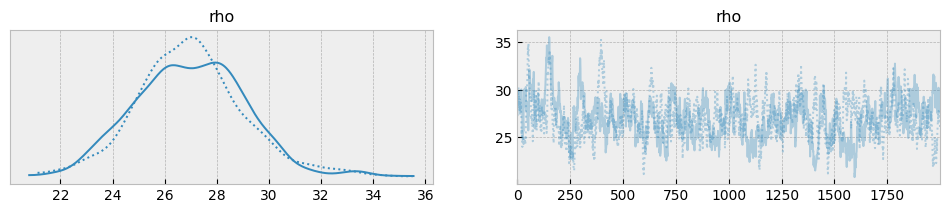

In [18]:
az.plot_trace(az_data, var_names=['rho']) # already checked gates and rates

<Axes: >

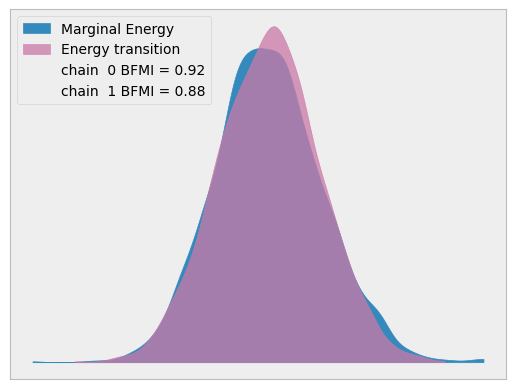

In [19]:
az.plot_energy(az_data) # the algorithm explored the energy space well

<Axes: title={'center': 'rho'}>

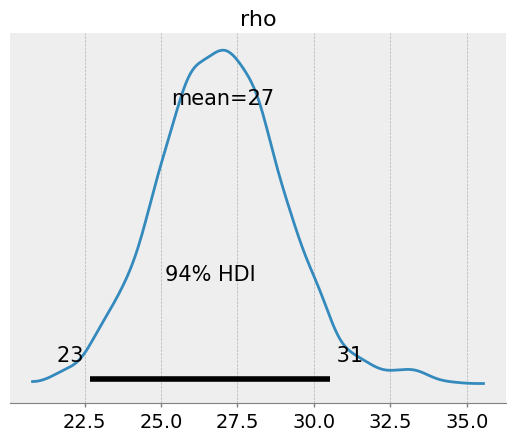

In [20]:
az.plot_posterior(az_data, var_names=['rho']) # only the posterior of the concentration is shown

/Users/alex/CAPE/BDA/kidney-cancer/.venv/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (50) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'phi\n0'}>,
        <Axes: title={'center': 'phi\n1'}>,
        <Axes: title={'center': 'phi\n2'}>,
        <Axes: title={'center': 'phi\n3'}>],
       [<Axes: title={'center': 'phi\n4'}>,
        <Axes: title={'center': 'phi\n5'}>,
        <Axes: title={'center': 'phi\n6'}>,
        <Axes: title={'center': 'phi\n7'}>],
       [<Axes: title={'center': 'phi\n8'}>,
        <Axes: title={'center': 'phi\n9'}>,
        <Axes: title={'center': 'phi\n10'}>,
        <Axes: title={'center': 'phi\n11'}>],
       [<Axes: title={'center': 'phi\n12'}>,
        <Axes: title={'center': 'phi\n13'}>,
        <Axes: title={'center': 'phi\n14'}>,
        <Axes: title={'center': 'phi\n15'}>],
       [<Axes: title={'center': 'phi\n16'}>,
        <Axes: title={'center': 'phi\n17'}>,
        <Axes: title={'center': 'phi\n18'}>,
        <Axes: title={'center': 'phi\n19'}>],
       [<Axes: title={'center': 'phi\n20'}>,
        <Axes: title={'center': 'phi\n21'}>,
        <Axes: 

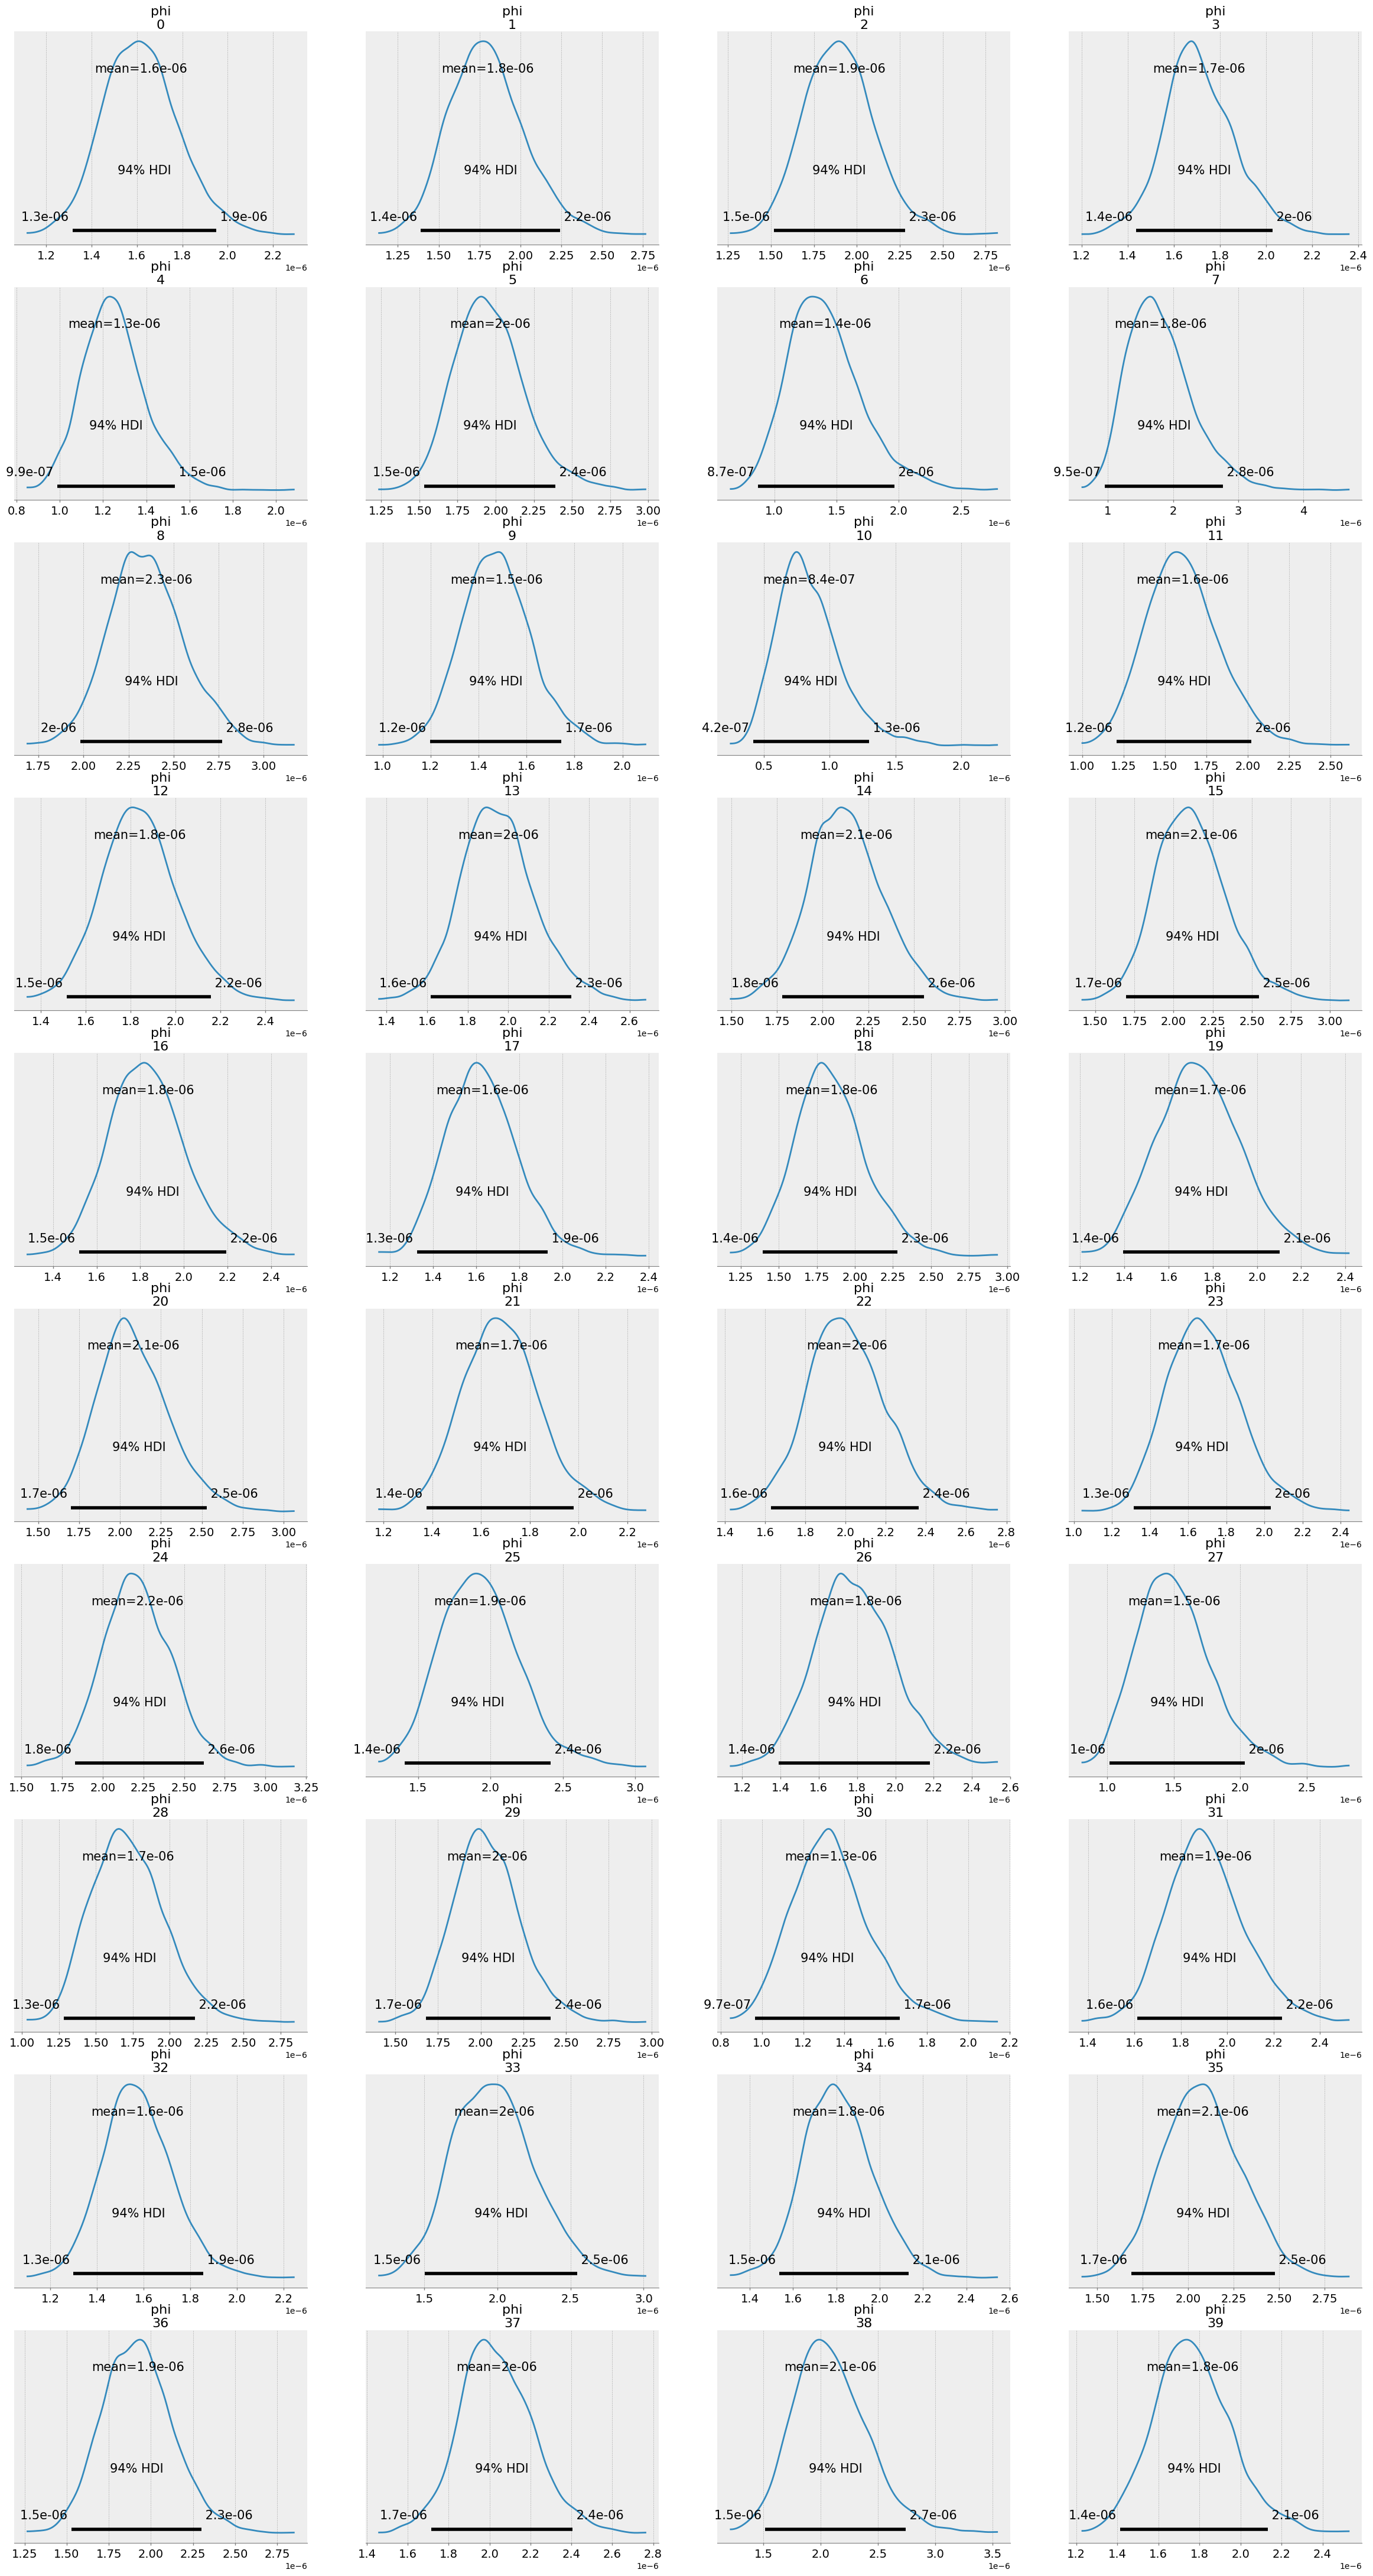

In [21]:
az.plot_posterior(az_data, var_names=['phi']) # only the posterior of the concentration is shown

In [22]:
# az.plot_forest(az_data, combined = True, hdi_prob = 0.95, r_hat = True)

In [23]:
pred_death = np.median(posterior_predictive['death'], axis = 0)

<Axes: ylabel='Count'>

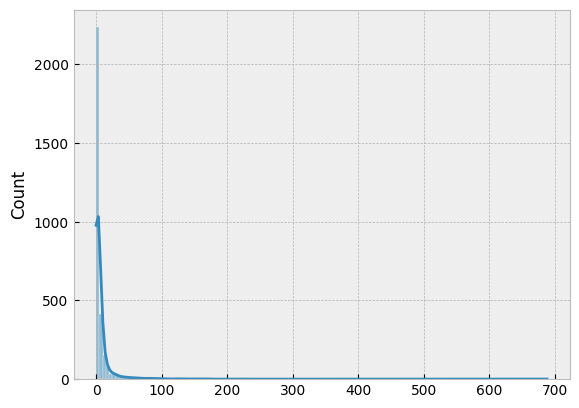

In [24]:
sns.histplot(pred_death, kde = True, binwidth=5)

<Axes: xlabel='dc', ylabel='Count'>

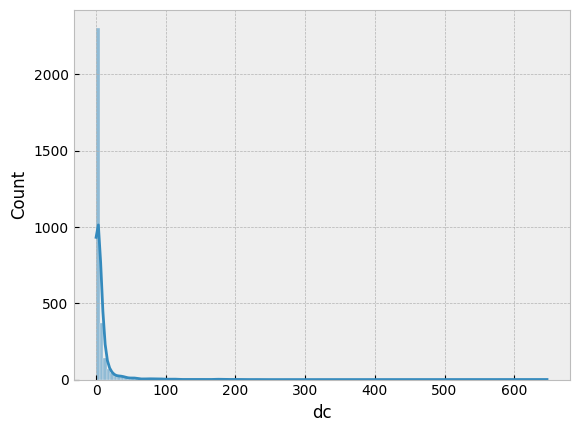

In [25]:
sns.histplot(df.dc, kde = True, binwidth=5)

From the perspective of median, we can observe that the predicted distribution is close to the observed distribution, indicating that the model performs well.

Besides, the number of 0s is close.

In [26]:
np.where(posterior_predictive['death'][0] == 0, True, False).sum()

np.int64(753)

In [27]:
df.loc[df.dc == 0].shape

(594, 7)

Using the helper function defined below, we can get insights from models on the prediction of the number of deaths.

In [28]:
def find_loc(i: int):
    """
    Plot the posterior predictive distribution of death for a specific location.
    The red vertical line indicates the observed death count.

    Args:
    i: int, the location index

    Returns:
    None
    """
    sns.histplot(posterior_predictive['death'][:, i], kde = True)
    plt.vlines(df.dc[i], 0, 100, color = 'red')
    plt.title(f'Location {i}')

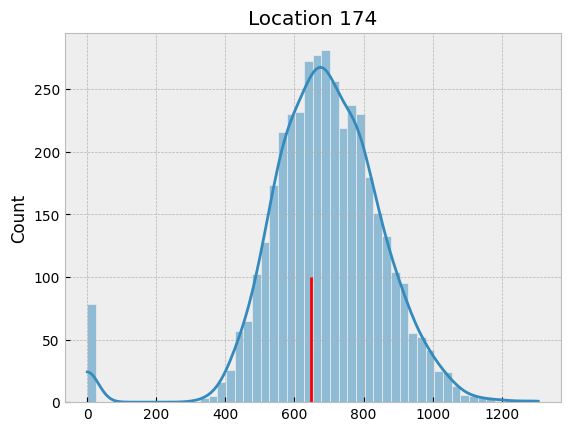

In [29]:
find_loc(174)

In [30]:
df.loc[df.dc >= 200, :] # the locations with the high death count

,state,Location,dc,dc.2,pop,pop.2,rate
174,CALIFORNIA,"Los Angeles County, California",647,598,15266402,16607891,0.000042
331,FLORIDA,"Miami-Dade County, Florida",227,207,3278943,3465460,0.000069
578,ILLINOIS,"Cook County, Illinois",503,549,9080516,8901701,0.000055
1835,NEW.YORK,"Queens County, New York",208,186,3279555,3122769,0.000063


# Prediction

In this section, I compare the performance of Bayesian model, linear regression, and naive bayes, evaluated by MSE and $R^2$.

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [32]:
X = df[['state', 'pop']]
y = df['dc']
X_dum = pd.get_dummies(X, columns = ['state'], drop_first = True)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed_split)
X_train_dum, X_test_dum, y_train_dum, y_test_dum = train_test_split(X_dum, y, test_size = 0.2, random_state = seed_split)

In [34]:
scaler = StandardScaler()
X_train_dum[['pop']] = scaler.fit_transform(X_train_dum[['pop']])
X_test_dum[['pop']] = scaler.transform(X_test_dum[['pop']])

## Linear Regression

In [35]:
lr = LinearRegression()
lr.fit(X_train_dum, y_train_dum)

LinearRegression()

In [36]:
print(f'MSE: {mean_squared_error(y_test_dum, lr.predict(X_test_dum))}\n R2: {r2_score(y_test_dum, lr.predict(X_test_dum))}')

MSE: 37.38694708102523
 R2: 0.9660449175150774


## Naive Bayes

In [37]:
nb = GaussianNB()
nb.fit(X_train_dum, y_train_dum)

GaussianNB()

In [38]:
print(f'MSE: {mean_squared_error(y_test_dum, nb.predict(X_test_dum))}\n R2: {r2_score(y_test_dum, nb.predict(X_test_dum))}')

MSE: 1603.072347266881
 R2: -0.45592133165564697


## Bayesian

In [39]:
state_list = list(df['state'].unique())

train_location = []
for i in range(len(X_train)):
    train_location.append(state_list.index(X_train['state'].values.copy()[i]))

test_location = []
for i in range(len(X_test)):
    test_location.append(state_list.index(X_test['state'].values.copy()[i]))

In [40]:
train_data = dict()
train_data['death'] = y_train.values.copy()
train_data['location'] = np.array(train_location, dtype = int)
train_data['population'] = X_train['pop'].values.copy()

mcmc_com = _run_model(model, train_data)
mcmc_com.print_summary()

/var/folders/zz/x65716_j4s7947htd3809l4h0000gn/T/ipykernel_89050/983848280.py:37: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 3000/3000 [00:39<00:00, 76.51it/s, 31 steps of size 1.08e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  kappa[0]      0.04      0.03      0.03      0.00      0.09   6757.39      1.00
  kappa[1]      0.07      0.06      0.05      0.00      0.15   7156.81      1.00
  kappa[2]      0.04      0.03      0.03      0.00      0.08   5721.77      1.00
  kappa[3]      0.02      0.02      0.02      0.00      0.05   5582.33      1.00
  kappa[4]      0.03      0.03      0.02      0.00      0.08   5909.94      1.00
  kappa[5]      0.08      0.07      0.05      0.00      0.17   6184.87      1.00
  kappa[6]      0.11      0.10      0.08      0.00      0.25   5534.75      1.00
  kappa[7]      0.14      0.12      0.11      0.00      0.32   6953.37      1.00
  kappa[8]      0.04      0.03      0.03      0.00      0.09   6403.77      1.00
  kappa[9]      0.04      0.03      0.03      0.00      0.08   5870.77      1.00
 kappa[10]      0.15      0.12      0.12      0.00      0.32   6747.48      1.00
 kappa[11]      0.05      0

In [41]:
test_data = dict()
test_data['location'] = np.array(test_location, dtype = int)
test_data['population'] = X_test['pop'].values.copy()

In [42]:
_, rng_key = random.split(seed_jax_rng)
samples_com = mcmc_com.get_samples()

posterior_predictive = Predictive(model, samples_com)(
    rng_key, test_data['location'], test_data['population']
)

In [43]:
y_pred = posterior_predictive['death'].mean(axis = 0)

In [44]:
# change device from TFRT_CPU_0 to cpu

y_pred = np.array(y_pred)

In [45]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}\n R2: {r2_score(y_test, y_pred)}')

MSE: 15.525618553161621
 R2: 0.9858995079994202


From the results above, we find that the Bayesian model outperforms the others. Moreover, it offers greater explainability, enabling users to easily obtain estimates of both the probability of death from kidney cancer and mortality rates in each state. The model's logic is more straightforward to understand, effectively describing our approach to data analysis and process methodology. The fitting results, in turn, enhance our understanding of the underlying mechanism. Overall, Bayesian models help us describe data in alignment with our prior beliefs.